In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Display the row's columns and data in dictionary format
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b7f5ffdcf0>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08}

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#date_range_end = most_recent_date[0]
# Calculate the date one year from the last date in data set.
date_range_begin = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

print(date_range_begin)

2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_range_begin).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_query, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any')

# Sort the dataframe by date
precipitation_df.set_index('Date',  inplace=True)
precipitation_df = precipitation_df.sort_values(['Date'], ascending=True)
precipitation_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


<Axes: xlabel='Date', ylabel='Inches'>

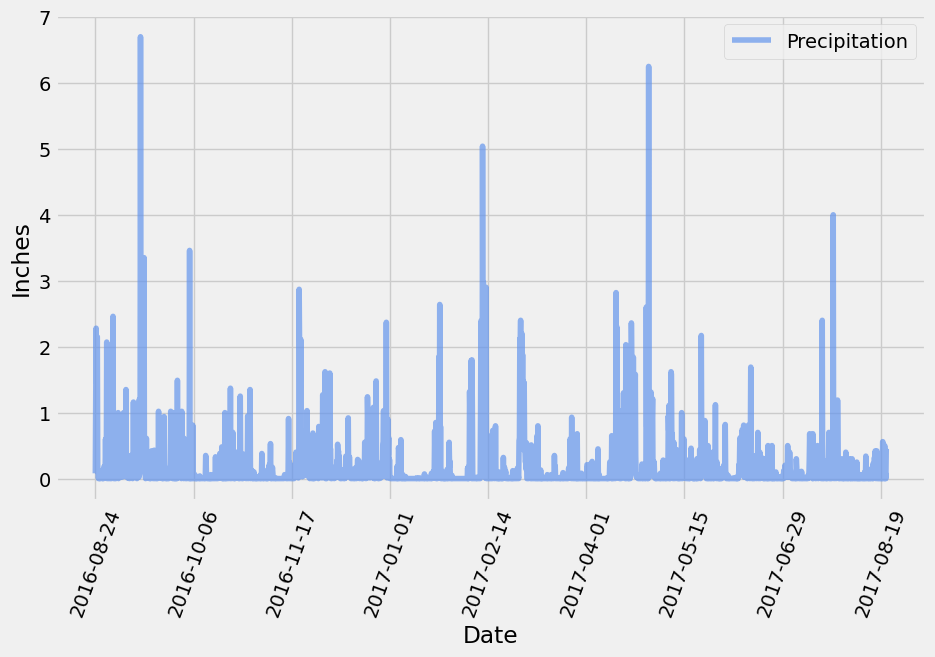

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(xlabel='Date', ylabel='Inches', color='cornflowerblue', alpha=.7, rot=70, figsize=(10,6))

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Display the row's columns and data in dictionary format
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b7f630b310>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.id).count()
print(station_count)

9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_actions = session.query(Measurement.station, func.count(Measurement.date)).\
        group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
station_actions

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active_station = station_actions[0][0]
most_active_station

'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station).\
        group_by(Measurement.station).first()
most_active
print(f"The lowest temperature of the most active station is {most_active[0]}")
print(f"The highest temperature of the most active station is {most_active[1]}")
print(f"The average temperature of the most active station is {most_active[2]}")

The lowest temperature of the most active station is 54.0
The highest temperature of the most active station is 85.0
The average temperature of the most active station is 71.66378066378067


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_query = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= date_range_begin).\
                    filter(Measurement.station == most_active_station).\
                    group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temperature_df = pd.DataFrame(temperature_query, columns=['Dates', 'tobs'])
temperature_df.head()

,Dates,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


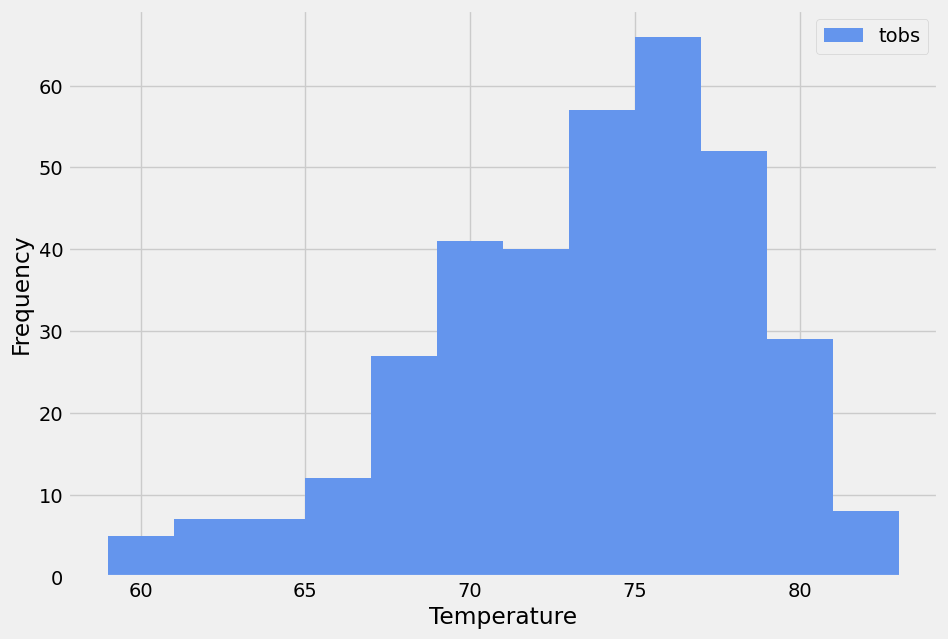

In [21]:
#Create the histogram of the last 12 months of the most active station
temperature_df.plot.hist(xlabel='Temperature', ylabel='Frequency', color='cornflowerblue', bins=12, figsize=(10, 7))
plt.legend()
plt.show()

# Close Session

In [22]:
# Close Session
session.close()